In [1]:
import pandas as pd
import numpy as np
import math
from sklearn import datasets, linear_model, metrics, feature_extraction, model_selection
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
%matplotlib inline

In [2]:
df = pd.read_csv("train_dataset.csv")

In [3]:
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,ArrTime,UniqueCarrier,FlightNum,TailNum,AirTime,Origin,Dest,Distance,TaxiIn,TaxiOut,target
0,1,1,2,1007.0,1109.0,AA,511,N404AA,34.0,AUS,DFW,190,15.0,13.0,1
1,1,1,2,1411.0,1521.0,NW,1631,N363NB,37.0,TVC,DTW,207,9.0,24.0,1
2,1,1,2,859.0,1112.0,MQ,4645,N700LE,103.0,BDL,RDU,532,3.0,27.0,0
3,1,1,2,1835.0,2159.0,MQ,4838,N704PG,130.0,XNA,LGA,1147,6.0,8.0,1
4,1,1,2,1305.0,1924.0,US,185,N655AW,229.0,PHX,FLL,1972,9.0,21.0,1


In [27]:
df = df.drop(df[df["AirTime"] == 0].index)

In [4]:
df["TailNum"] = df["TailNum"].fillna("UNKNOWN")

In [5]:
df['TaxiOut'] = df['TaxiOut'].fillna(df['TaxiOut'].mean())

df['AirTime'] = df['AirTime'].fillna(df['AirTime'].mean())

df['DepTime'] = df['DepTime'].fillna(df['DepTime'].mean())

df['ArrTime'] = df['ArrTime'].fillna(df['ArrTime'].mean())

df['TaxiIn'] = df['TaxiIn'].fillna(df['TaxiIn'].mean())

In [6]:
seasons = ("-", "W", "W", "P", "P", "P", "S", "S", "S", "A", "A", "A", "W")
df["Season"] = df["Month"].map(lambda m: seasons[m])

In [7]:
def reclassMean(frame, targetSrc, clsName, meanName, targetExtractor = lambda f, c: f.groupby(c)["target"].mean()):
    def getMean(c, meanInfo): 
        if c not in meanInfo:
            meanInfo[c] = meanInfo.mean()
        return meanInfo[c]
    meanInfo = targetExtractor(targetSrc, clsName)
    frame[meanName] = frame[clsName].map(lambda c: getMean(c, meanInfo))

In [8]:
reclassMean(df, df, "UniqueCarrier", "CarrierChance")
#reclassMean(df, df, "Dest", "DestChance")
reclassMean(df, df, "Origin", "OriginChance")
reclassMean(df, df, "TailNum", "PlaneChance")
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,ArrTime,UniqueCarrier,FlightNum,TailNum,AirTime,Origin,Dest,Distance,TaxiIn,TaxiOut,target,Season,CarrierChance,OriginChance,PlaneChance
0,1,1,2,1007.0,1109.0,AA,511,N404AA,34.0,AUS,DFW,190,15.0,13.0,1,W,0.330748,0.249355,0.315904
1,1,1,2,1411.0,1521.0,NW,1631,N363NB,37.0,TVC,DTW,207,9.0,24.0,1,W,0.238788,0.235487,0.199134
2,1,1,2,859.0,1112.0,MQ,4645,N700LE,103.0,BDL,RDU,532,3.0,27.0,0,W,0.302457,0.235227,0.324830
3,1,1,2,1835.0,2159.0,MQ,4838,N704PG,130.0,XNA,LGA,1147,6.0,8.0,1,W,0.302457,0.263668,0.297125
4,1,1,2,1305.0,1924.0,US,185,N655AW,229.0,PHX,FLL,1972,9.0,21.0,1,W,0.231669,0.297125,0.244681


In [9]:
def split_time(time):
    time = str(int(time))
    time = ('0' * (4 - len(time))) + time
    hours = int(time[0:2])
    minutes = int(time[2:4])
    return {"H": hours, "M": minutes}


def reclass_time(frame, orig, hours, minutes): 
    t = frame[orig].map(split_time)
    frame[hours] = t.map(lambda t: t["H"])
    frame[minutes] = t.map(lambda t: t["M"])

In [10]:
reclass_time(df, "DepTime", "DepHour", "DepMinute")
reclass_time(df, "ArrTime", "ArrHour", "ArrMinute")
df["DepTotalMinutes"] = df["DepHour"] * 60 + df["DepMinute"]
df["ArrTotalMinutes"] = df["ArrHour"] * 60 + df["ArrMinute"]
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,ArrTime,UniqueCarrier,FlightNum,TailNum,AirTime,Origin,...,Season,CarrierChance,OriginChance,PlaneChance,DepHour,DepMinute,ArrHour,ArrMinute,DepTotalMinutes,ArrTotalMinutes
0,1,1,2,1007.0,1109.0,AA,511,N404AA,34.0,AUS,...,W,0.330748,0.249355,0.315904,10,7,11,9,607,669
1,1,1,2,1411.0,1521.0,NW,1631,N363NB,37.0,TVC,...,W,0.238788,0.235487,0.199134,14,11,15,21,851,921
2,1,1,2,859.0,1112.0,MQ,4645,N700LE,103.0,BDL,...,W,0.302457,0.235227,0.324830,8,59,11,12,539,672
3,1,1,2,1835.0,2159.0,MQ,4838,N704PG,130.0,XNA,...,W,0.302457,0.263668,0.297125,18,35,21,59,1115,1319
4,1,1,2,1305.0,1924.0,US,185,N655AW,229.0,PHX,...,W,0.231669,0.297125,0.244681,13,5,19,24,785,1164


In [28]:
speed_df = df[df["target"] == 0][["TailNum", "AirTime", "Distance"]].groupby("TailNum")\
.apply(lambda r: r["Distance"] / r["AirTime"])
reclassMean(df, speed_df, "TailNum", "Speed", lambda f, c: f.groupby(c).mean())

In [42]:
df["EstAirTime"] = df["Distance"] / df["Speed"]
df["TimeDiff"] = df["AirTime"] - df["EstAirTime"]

In [43]:
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,ArrTime,UniqueCarrier,FlightNum,TailNum,AirTime,Origin,...,PlaneChance,DepHour,DepMinute,ArrHour,ArrMinute,DepTotalMinutes,ArrTotalMinutes,Speed,EstAirTime,TimeDiff
0,1,1,2,1007.0,1109.0,AA,511,N404AA,34.0,AUS,...,0.315904,10,7,11,9,607,669,6.919396,27.459046,6.540954
1,1,1,2,1411.0,1521.0,NW,1631,N363NB,37.0,TVC,...,0.199134,14,11,15,21,851,921,6.851220,30.213599,6.786401
2,1,1,2,859.0,1112.0,MQ,4645,N700LE,103.0,BDL,...,0.324830,8,59,11,12,539,672,5.910461,90.009904,12.990096
3,1,1,2,1835.0,2159.0,MQ,4838,N704PG,130.0,XNA,...,0.297125,18,35,21,59,1115,1319,5.843790,196.276719,-66.276719
4,1,1,2,1305.0,1924.0,US,185,N655AW,229.0,PHX,...,0.244681,13,5,19,24,785,1164,7.294158,270.353329,-41.353329


In [75]:
df[df["TimeDiff"] < -35]["target"].mean()

0.32832913754937282

In [30]:
dropped_cols = ["UniqueCarrier", "Origin", "Dest", "FlightNum", "TailNum", "Season"]
oh_cols = ["DayOfWeek", "Month"]
clf_num = df.drop(dropped_cols + oh_cols, axis=1)
clf_oh = pd.get_dummies(df.loc[:, oh_cols], columns=oh_cols, dummy_na=False)
clf_df = pd.concat([clf_num, clf_oh], axis=1, join='inner')

In [31]:
clf_df.head()

,DayofMonth,DepTime,ArrTime,AirTime,Distance,TaxiIn,TaxiOut,target,CarrierChance,OriginChance,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,1,1007.0,1109.0,34.0,190,15.0,13.0,1,0.330748,0.249355,...,0,0,0,0,0,0,0,0,0,0
1,1,1411.0,1521.0,37.0,207,9.0,24.0,1,0.238788,0.235487,...,0,0,0,0,0,0,0,0,0,0
2,1,859.0,1112.0,103.0,532,3.0,27.0,0,0.302457,0.235227,...,0,0,0,0,0,0,0,0,0,0
3,1,1835.0,2159.0,130.0,1147,6.0,8.0,1,0.302457,0.263668,...,0,0,0,0,0,0,0,0,0,0
4,1,1305.0,1924.0,229.0,1972,9.0,21.0,1,0.231669,0.297125,...,0,0,0,0,0,0,0,0,0,0


In [32]:
shuffled_df = clf_df.sample(frac=1)
labels = shuffled_df["target"]
clf_train, clf_test, label_train, label_test = model_selection.train_test_split(shuffled_df.drop("target", axis=1), labels, test_size = 0.3)

In [33]:
clf = linear_model.LogisticRegression()
param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5]}
opt = model_selection.GridSearchCV(clf, param_grid, cv=3, n_jobs=2, return_train_score=True)

In [34]:
opt.fit(clf_train, label_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [35]:
for i, c in enumerate(opt.best_estimator_.coef_[0]):
    print("%s: %f" % (clf_df.columns[i], c))

DayofMonth: -0.002452
DepTime: -0.379583
ArrTime: -0.188936
AirTime: -0.002894
Distance: 0.000516
TaxiIn: -0.005335
TaxiOut: 0.014104
target: 0.302168
CarrierChance: 0.291721
OriginChance: 1.497190
PlaneChance: 0.014866
DepHour: -0.257733
DepMinute: 0.007403
ArrHour: -0.129497
ArrMinute: 0.634240
DepTotalMinutes: 0.314658
ArrTotalMinutes: -0.108888
Speed: -0.223789
DayOfWeek_1: -0.419238
DayOfWeek_2: -0.421841
DayOfWeek_3: -0.247324
DayOfWeek_4: -0.012823
DayOfWeek_5: -0.295859
DayOfWeek_6: -0.192992
DayOfWeek_7: -0.026755
Month_1: 0.071892
Month_2: 0.048795
Month_3: -0.172043
Month_4: -0.195005
Month_5: 0.046854
Month_6: -0.081219
Month_7: -0.157706
Month_8: -0.591086
Month_9: -0.511348
Month_10: -0.432950
Month_11: 0.186703


In [36]:
opt.cv_results_

{'mean_fit_time': array([ 82.45113881,  79.07010682,  81.67737182,  81.28178382,
         96.72101927,  85.67164961]),
 'mean_score_time': array([ 0.34100374,  0.38467781,  0.35440183,  0.40103181,  0.4165562 ,
         0.36803595]),
 'mean_test_score': array([ 0.71834871,  0.72347506,  0.72524404,  0.72586155,  0.72490533,
         0.72346936]),
 'mean_train_score': array([ 0.71835237,  0.72348994,  0.72528011,  0.72592187,  0.72509955,
         0.72352989]),
 'param_C': masked_array(data = [0.01 0.05 0.1 0.5 1 5],
              mask = [False False False False False False],
        fill_value = ?),
 'params': [{'C': 0.01},
  {'C': 0.05},
  {'C': 0.1},
  {'C': 0.5},
  {'C': 1},
  {'C': 5}],
 'rank_test_score': array([6, 4, 2, 1, 3, 5], dtype=int32),
 'split0_test_score': array([ 0.71334713,  0.72058117,  0.72324319,  0.72604215,  0.72711699,
         0.72269048]),
 'split0_train_score': array([ 0.71372367,  0.72102925,  0.7236014 ,  0.7262891 ,  0.72777113,
         0.72293192]),
 'spl

In [37]:
pred = opt.predict(clf_test)

In [38]:
predpr = opt.predict_proba(clf_test)

In [39]:
metrics.accuracy_score(label_test, pred)

0.72034926739822225

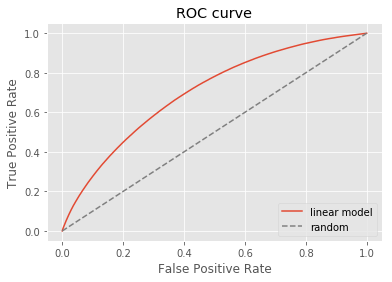

In [40]:
fpr, tpr, _ = metrics.roc_curve(label_test, predpr[:,1])
plt.plot(fpr, tpr, label = 'linear model')
plt.plot([0, 1], [0, 1], '--', color = 'grey', label = 'random')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc = "lower right");

In [41]:
metrics.roc_auc_score(label_test, predpr[:,1])

0.70011727243217026

In [268]:
test_df = pd.read_csv("test_dataset.csv")

In [269]:
test_df["TailNum"] = test_df["TailNum"].fillna("UNKNOWN")

test_df['TaxiOut'] = test_df['TaxiOut'].fillna(df['TaxiOut'].mean())

test_df['AirTime'] = test_df['AirTime'].fillna(df['AirTime'].mean())

test_df['DepTime'] = test_df['DepTime'].fillna(df['DepTime'].mean())

test_df['ArrTime'] = test_df['ArrTime'].fillna(df['ArrTime'].mean())

test_df['TaxiIn'] = test_df['TaxiIn'].fillna(df['TaxiIn'].mean())

In [270]:
test_df["Season"] = test_df["Month"].map(lambda m: seasons[m])

In [283]:
reclassMean(test_df, df, "UniqueCarrier", "CarrierChance")
reclassMean(test_df, df, "Dest", "DestChance")
reclassMean(test_df, df, "Origin", "OriginChance")
reclassMean(test_df, df, "TailNum", "Speed")

In [284]:
test_clf_df = test_df.drop(dropped_cols, axis=1)
test_clf_cat = test_clf_df[oh_cols]

In [273]:
dv = feature_extraction.DictVectorizer(sparse=False)
test_clf_oh = dv.fit_transform(test_clf_cat.T.to_dict().values())

In [285]:
test_clf_num = test_clf_df.drop(oh_cols + ["Id"], axis=1)

In [286]:
test_clf = np.concatenate((test_clf_num, test_clf_oh), axis=1)

In [287]:
test_clf.shape

(3504864, 17)

In [288]:
test_pred = opt.predict_proba(test_clf)

In [289]:
test_pred[:, 1]

array([ 0.55668857,  0.53579349,  0.50382141, ...,  0.29191245,
        0.3603659 ,  0.29777507])

In [290]:
test_pred_df = pd.DataFrame(test_pred[:, 1], columns=["Prediction1"])

In [291]:
test_pred_df.index.name = "Id"

In [292]:
test_pred_df.head()

,Prediction1
Id,
0,0.556689
1,0.535793
2,0.503821
3,0.416603
4,0.387405


In [293]:
test_pred_df.to_csv("sample_1.csv")